In [7]:
#imports
import splat
import wisps
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns

%matplotlib inline
import splat.photometry as sphot
import splat.core as spl
import splat.empirical as spe
import splat.simulate as spsim
import matplotlib as mpl
from tqdm import tqdm


from astropy import stats as astrostats

In [2]:
#constants 
grid=np.sort(np.random.uniform(1000, 4000,1000))

#best_dict={'2MASS J': {\
#            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
#            'values': [10.36,10.77,11.15,11.46,11.76,12.03,12.32,12.77,13.51,13.69,14.18,14.94,14.90,14.46,14.56,15.25,14.54,14.26,13.89,14.94,15.53,16.78,17.18,17.75],\
#            'rms': [0.30,0.30,0.42,0.34,0.18,0.15,0.21,0.24,0.28,0.25,0.60,0.20,0.13,0.71,0.5,0.12,0.06,0.16,0.36,0.12,0.27,0.76,0.51,0.5]},
#        '2MASS H': {\
#            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
#            'values': [9.76,10.14,10.47,10.74,11.00,11.23,11.41,11.82,12.45,12.63,13.19,13.82,13.77,13.39,13.62,14.39,13.73,13.67,13.57,14.76,15.48,16.70,17.09,17.51],\
#            'rms': [0.30,0.31,0.43,0.35,0.23,0.21,0.25,0.29,0.3,0.30,0.62,0.31,0.20,0.73,0.5,0.18,0.15,0.24,0.40,0.24,0.37,0.78,0.5,0.5]}}

In [3]:
#functions
def flux_calibrate_spectrum(row):
    try:
        #calibrate using absolute magnidtude
        sp=splat.getSpectrum(filename=row.DATA_FILE)[0]
        spt=splat.typeToNum(row.SPEX_TYPE)
        #use optical types for early dwarffs
        if (np.isnan(spt) | (spt <=15)):
            spt=splat.typeToNum(row.OPT_TYPE)
        #no need to flux calibrate, reject high uncertainty in classification types
        #absmag=row.J_2MASS-5*(np.log10(row.DISTANCE)-1)
        #sp.fluxCalibrate('2MASS J', absmag)
        return [spt, sp]
    except :
        return []
    

def make_mamajek_fit(spt):
    
    js=mamjk.M_J.apply(float).values
    jminush=mamjk['J-H'].apply(float).values
    hs=js-jminush
    
    spts=mamjk.SpT.apply(wisps.make_spt_number).apply(float).values
    
    hsortedindex=np.argsort(hs)
    jsortedindex=np.argsort(js)
    
    hval=np.interp(spt,  spts[hsortedindex], hs[hsortedindex])
    jval=np.interp(spt,  spts[jsortedindex], js[jsortedindex])
    
    return ((jval, 0.4), (hval, 0.4))


def absolute_mag_best(spt, flt):
    #
    mags=wisps.best_dict[flt]
    spts=np.array(mags['spt'])
    if (spt < spts.min()) | (spt> spts.max()):
        return np.nan
    else:
        vals=np.array(mags['values'])
        rms=np.array(mags['rms'])

        sortedindex=np.argsort(vals)


        val=np.interp(spt,  spts[sortedindex], vals[sortedindex])
        rmsv=np.interp(spt, spts[sortedindex], rms[sortedindex])
        
        vals=np.random.normal(val, rmsv, 1000)
        return vals.mean(), vals.std()
    

def get_abs_mag(spt):
    
    spt=wisps.make_spt_number(spt)
    
    if spt < 37:
        (j, junc), (h, hunc)=  make_mamajek_fit(spt)
        
    if (spt >= 37):
        h=wisps.absolute_mag_kirkpatrick(spt, '2MASS H')
        (j, junc), (_, _)= make_mamajek_fit(spt)
        hunc=0.7
    return [[j, junc], [h, hunc]]
    
def schn_flux_calibrate(row):
    sp=row.spectra.splat_spectrum
    spt=splat.typeToNum(row.Spec)
    sp.fluxCalibrate('MKO J',float(row.J_MKO))
    return [spt, sp]

def get_colors(sp, flt):
    #measuring filtermags in for two filters and comparing that to target filters
    #remember to include euclid filters
    #using splat filtermag
    mag, mag_unc = splat.filterMag(sp, flt)
    #calculate the mag of the standard in J and H
    
    magj, mag_uncj = splat.filterMag(sp,'2MASS J')
    magh, mag_unch = splat.filterMag(sp,'2MASS H')
    #calculate the offset between HST filters and 2mass filters but add the uncertainty
    
    offsetj=magj-mag
    offseth=magh-mag
    
    unc1=(mag_unc**2+mag_uncj**2)**0.5
    unc2=(mag_unc**2+mag_unch**2)**0.5
    
    #offsetj=np.random.normal(offsetj, unc1)
    #offseth=np.random.normal(offseth, unc2)
    return [[offsetj, offseth], [unc1, unc2]]


def get_abs_hst_mag(color, mag0):
    return mag0-color


def k_clip_fit(x, y, sigma_y, sigma = 5, n=6):
    
    '''Fit a polynomial to y vs. x, and k-sigma clip until convergence'''
    
    not_clipped = np.ones_like(y).astype(bool)
    n_remove = 1
    
    #use median sigma
    #median_sigma= np.nanmedian(sigma_y)
    
    while n_remove > 0:

        best_fit = np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))
        
        norm_res = (np.abs(y - best_fit(x)))/(sigma_y)
        remove = np.logical_and(norm_res >= sigma, not_clipped == 1)
        n_remove = sum(remove)
        not_clipped[remove] = 0   
        
    return  not_clipped

def fit_with_nsigma_clipping(x, y, y_unc, n, sigma=3.):
    not_clipped = k_clip_fit(x, y, y_unc, sigma = sigma)
    return not_clipped, np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))

In [4]:

#load spectra, ignore binaries, objects with high uncertainty in mag and objects without parallaxes
splat_db=splat.searchLibrary(vlm=True, giant=False, young=False, binary=False)
splat_db['SHORTNAME']=splat_db.DESIGNATION.apply(lambda x: splat.designationToShortName)
#sml=splat_db[~ ((splat_db.H_2MASS_E > 0.1) | (splat_db.J_2MASS_E > 0.1) | (splat_db.MEDIAN_SNR <20)  )]
sml=splat_db[~ ((splat_db.H_2MASS_E > 0.3) | (splat_db.J_2MASS_E > 0.3)  |
                (splat_db.SPEX_TYPE.apply(splat.typeToNum) <15))]

#sds=sml[(sml.METALLICITY_CLASS=='sd') | (sml.METALLICITY_CLASS=='esd')  ]
sml=sml[~((sml.METALLICITY_CLASS=='sd') | (sml.METALLICITY_CLASS=='esd') \
          | (sml.MEDIAN_SNR <20))]

In [5]:
mdwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum) <20)]
ldwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum).between(20, 30))]
tdwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum).between(30, 40))]

#tighter_constraints on m dwarfs 
mdwarfs=mdwarfs[(~mdwarfs.PARALLAX.isna()) & (mdwarfs.MEDIAN_SNR >100)]
ldwarfs=ldwarfs[ (ldwarfs.MEDIAN_SNR >70)]

def choose_ten(df):
    if len(df) >10:
        return df.sort_values('MEDIAN_SNR', ascending=False)[:10]
    else:
        return df
ls=ldwarfs.groupby('SPEX_TYPE').apply(choose_ten).reset_index(drop=True)#.groupby('SPEX_TYPE').count()

In [19]:
#get y dwarfs
def get_shortname(n):
    return splat.designationToShortName(n).replace('J', 'WISE')
schn='/Users/caganze/research/wisps/data/schneider/*.txt'
schntb=pd.read_csv('/Users/caganze/research/wisps/data/schneider2015.txt', 
                   delimiter=' ').drop(columns='Unnamed: 14')
schntb['shortname']=schntb.Name.apply(get_shortname)
spectra_schn=[]
from astropy.io import ascii
for f in glob.glob(schn):
    d=ascii.read(f).to_pandas()
    shortname=(f.split('/')[-1]).split('.txt')[0]
    s=splat.Spectrum(wave=d.col1, 
                     flux=d.col2,
                     noise=d.col3, 
                     name=shortname)
    #measure snr 
    mask= np.logical_and(d.col1>1.0, d.col1<2.4)
    snr= (np.nanmedian(d.col2[mask]/d.col3[mask]))
    spectra_schn.append([s, snr])

In [12]:
#schn_merged=(schn_merged[schn_merged.snr1>10]).reset_index(drop=True)
smlf=pd.concat([mdwarfs, ls, tdwarfs]).reset_index(drop=True)

In [13]:
def make_spt_number(spt):
    ##make a spt a number
    if isinstance(spt, str):
        return splat.typeToNum(spt)
    else:
        return spt

In [14]:
%%capture
templs=smlf.DATA_FILE.apply(lambda x: splat.getSpectrum(filename=x)[0])

In [20]:
schntb['spectra']=[x[0] for x in  spectra_schn]

schntb['snr']=[x[1] for x in  spectra_schn]

schntb=schntb[schntb.snr>=2.].reset_index(drop=True)

all_spectra=np.concatenate([templs,schntb.spectra.values ])

In [21]:
spts=np.concatenate([smlf.SPEX_TYPE.apply(make_spt_number).values,
                     schntb.Spec.apply(make_spt_number).values,
                    ])
assert len(spts) == len(all_spectra)

In [22]:
from astropy.io import ascii
mamjk=ascii.read('/users/caganze/research/wisps/data/mamajek_relations.txt').to_pandas().replace('None', np.nan)

In [39]:
#combined calibrated spctra
#combcal=np.append(calbr, calbrschn)
#specs=np.array([x for x in pd.DataFrame(combcal).values if x])
specs= list(zip(spts, all_spectra))

In [40]:


#compute colors for different filters
colors=[]
uncolors=[]
fltrswfc3= ['WFC3_{}'.format(k) for k in ['F110W', 'F140W', 'F160W']]
fltrseucl=['EUCLID_J', 'EUCLID_H']

fltrs=np.append(fltrswfc3, fltrseucl)
print (fltrs)
for pair in tqdm(specs):
    c={}
    uncclrs={}
    for flt in fltrs:
        x=pair[1]
        sptx=pair[0]
        color, uncc=get_colors(x, flt)
        c.update({flt: color})
        uncclrs.update({flt:uncc})
    uncolors.append(uncclrs)
    colors.append(c)

  0%|          | 0/336 [00:00<?, ?it/s]

['WFC3_F110W' 'WFC3_F140W' 'WFC3_F160W' 'EUCLID_J' 'EUCLID_H']


100%|██████████| 336/336 [06:13<00:00,  1.11s/it]


In [42]:
assert len(spts) ==len(colors)

In [43]:
sp_grid= spts
#sp_grid=sp_grid0[~nans]

In [44]:
colors_df=pd.DataFrame(colors)#[~nans]
uncolors_df=pd.DataFrame(uncolors)#[~nans]

In [45]:
colors_df['spt']=sp_grid
uncolors_df['spt']=sp_grid

In [46]:
colors_polynomials={}
for k in colors_df.columns:
    if k != 'spt':
        clrs=np.vstack(colors_df[k]).astype(float)
        uncs=np.vstack(uncolors_df[k]).astype(float)
    
        mask0, pc0=fit_with_nsigma_clipping( sp_grid,clrs[:,0], uncs[:,0],6, sigma=5.)
        mask1, pc1=fit_with_nsigma_clipping( sp_grid,clrs[:,1], uncs[:,1],6, sigma=5.)
        
        x0, y0, yunc0= sp_grid[mask0], clrs[:,0][mask0], uncs[:,0][mask0]
        x1, y1, yunc1= sp_grid[mask1], clrs[:,1][mask1], uncs[:,1][mask1]
        


        colors_polynomials.update({k+'_J': {'pol': pc0, 'mask':mask0, 
                                     'color':clrs[:,0], 'unc': uncs[:,0], 
                                    'scatter': 5.*np.abs(pc0(x0)- y0).mean() }, 
                            k+'_H': {'pol': pc1, 'mask':mask1, 'color': clrs[:,1] , 'unc': uncs[:,1] ,
                                     'scatter':  5.*np.abs(pc1(x1)- y1).mean() }})

In [47]:
two_mass_values=np.array([  get_abs_mag(x) for x in sp_grid])

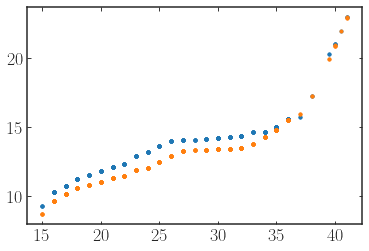

In [48]:
plt.plot(sp_grid, two_mass_values[:, 0][:, 0], '.')
plt.plot(sp_grid, two_mass_values[:, 1][:, 0], '.')

In [49]:
polynomial_relations={}

for k in colors_polynomials.keys():
    
    if k.endswith('J'): #use j-offset for j offset for h
        #take the median centered around the uncertainty 
        two_mass_to_use=two_mass_values[:, 0][:,0]
        two_mass_uncer= two_mass_values[:,0][:,1]
        
    else:
        two_mass_to_use=two_mass_values[:, 1][:,0]
        two_mass_uncer= two_mass_values[:,1][:,1]
        
    mask= np.logical_and.reduce([(colors_polynomials[k])['mask'], 
                                 ~np.isnan((colors_polynomials[k])['color']),
                                 ~np.isnan((colors_polynomials[k])['unc']), 
                                 ~np.isnan(two_mass_to_use)])
    
    #add values and propagate total uncertainty
    total_uncer=(two_mass_uncer**2+  (colors_polynomials[k])['unc']**2)**0.5
    
    vals0= np.random.normal(two_mass_to_use+ (colors_polynomials[k])['color'], total_uncer , 
                           size=( 1000, len(mask)))
    
    vals=vals0.mean(axis=0)
    uncs=vals0.std(axis=0)
  
    #only fit masked area 
    x=sp_grid[mask]
    y=vals[mask]
    yunc=total_uncer[mask]


    maskn, p=fit_with_nsigma_clipping(x,y,yunc,6, sigma=5.)


    polynomial_relations.update({k:{'x': x, 'y': y, 'pol': p, 'yunc': yunc, 'mask':maskn,
                                    'scatter': 5*(abs(p(x[maskn])-y[maskn])).mean()}})

In [50]:
wisps.kirkpa2019pol['scatter']

0.67

In [51]:
RMS_BEST={'J', np.array((wisps.best_dict['2MASS J']['rms'])).mean()**2 + 0.4**2, 
        'H', np.array((wisps.best_dict['2MASS H']['rms'])).mean()**2 + 0.4**2}

In [52]:
RMS_DAVY=wisps.kirkpa2019pol['scatter']

In [53]:
polynomial_relations.keys()

dict_keys(['WFC3_F110W_J', 'WFC3_F110W_H', 'WFC3_F140W_J', 'WFC3_F140W_H', 'WFC3_F160W_J', 'WFC3_F160W_H', 'EUCLID_J_J', 'EUCLID_J_H', 'EUCLID_H_J', 'EUCLID_H_H'])

In [54]:
final_pol_keys=['WFC3_F110W_J', 'WFC3_F140W_J', 'WFC3_F160W_H']

In [55]:
colors_polynomials[k].keys()

dict_keys(['pol', 'mask', 'color', 'unc', 'scatter'])

0.32355316644067666
0.3777508297692456
0.4030726545990418


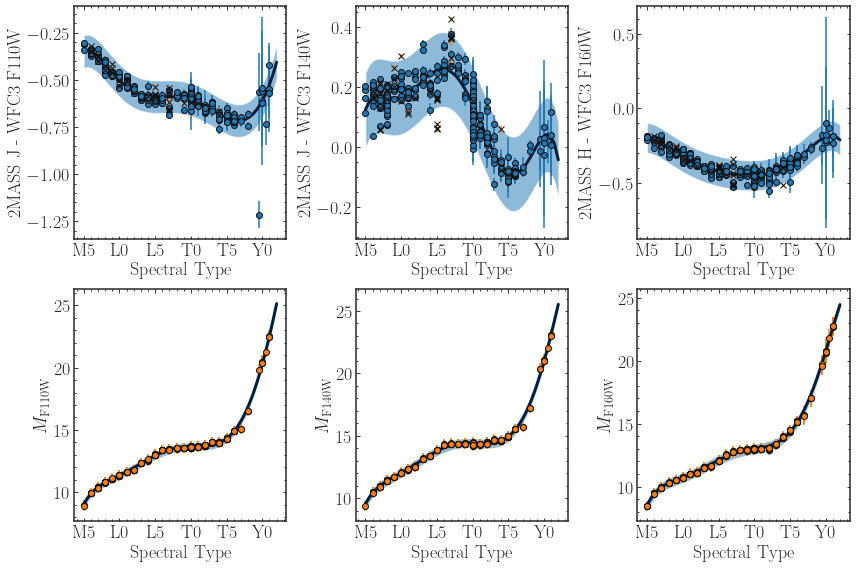

In [62]:
#visualize 
fig, (ax, ax1)=plt.subplots(ncols=3, figsize=(12, 8), nrows=2, sharey=False)

for  idx, k in zip(range(0, 10), final_pol_keys):
    
    pc=colors_polynomials[k]['pol']
    p=polynomial_relations[k]['pol']
    
    masked=colors_polynomials[k]['mask']
    maskedpol=polynomial_relations[k]['mask']
    scpol=polynomial_relations[k]['scatter']
    scolor=colors_polynomials[k]['scatter']
    
    print (scpol)
    ax[idx].plot(np.linspace(15, 42), pc(np.linspace(15, 42)), c='#001f3f', linewidth=3)
    ax1[idx].plot(np.linspace(15, 42), p(np.linspace(15, 42)), c='#001f3f', linewidth=3)
    
    ax[idx].fill_between(np.linspace(15, 42),  pc(np.linspace(15, 42))+scolor, pc(np.linspace(15, 42))-scolor, alpha=0.5 )
    
    ax1[idx].fill_between(np.linspace(15, 42),  p(np.linspace(15, 42))+scpol, p(np.linspace(15, 42))-scpol, alpha=0.5 )
    
    ax[idx].errorbar(sp_grid[mask], (colors_polynomials[k]['color'])[mask], yerr=(colors_polynomials[k]['unc'])[mask],   fmt='o', mec='#111111')
    
    ax[idx].errorbar(sp_grid[~mask], (colors_polynomials[k]['color'])[~mask], yerr= (colors_polynomials[k]['unc'])[~mask], fmt='x', mec='#111111')
    
    
    ax1[idx].errorbar(polynomial_relations[k]['x'][~maskedpol], polynomial_relations[k]['y'][~maskedpol],yerr=polynomial_relations[k]['yunc'][~maskedpol],  fmt='x', mec='#111111')
    ax1[idx].errorbar(polynomial_relations[k]['x'][maskedpol], polynomial_relations[k]['y'][maskedpol], yerr= polynomial_relations[k]['yunc'][maskedpol],  fmt='o', mec='#111111')
    
    
    #ax[idx].set_xlim([15, 42])
    #ax1[idx].set_xlim([15, 42])
    
    ax[idx].minorticks_on()
    ax1[idx].minorticks_on()
    
    
    ax[idx].set_xticks([15, 20, 25, 30, 35, 40])
    ax[idx].set_xticklabels(['M5', 'L0', 'L5', 'T0', 'T5', 'Y0'])
    
    ax1[idx].set_xticks([15, 20, 25, 30, 35, 40])
    ax1[idx].set_xticklabels(['M5', 'L0', 'L5', 'T0', 'T5', 'Y0'])
    
    ax[idx].set_xlabel('Spectral Type')
    ax1[idx].set_xlabel('Spectral Type')

    
    

    
#ax[0].set_ylim([-0.75, 0.0])
#ax[1].set_ylim([-.25, 0.5])
#ax[2].set_ylim([-.75, 0.25])

#ax1[0].set_ylim([8, 27])
#ax1[1].set_ylim([8, 27])
#ax1[2].set_ylim([7, 27])

#ax1[0].set_ylim([8, 27])


ax[0].set_ylabel('2MASS J - WFC3 F110W')
ax[1].set_ylabel('2MASS J - WFC3 F140W')
ax[2].set_ylabel('2MASS H - WFC3 F160W')

ax1[0].set_ylabel(r'$M_\mathrm{F110W}$')
ax1[1].set_ylabel(r'$M_\mathrm{F140W}$')
ax1[2].set_ylabel(r'$M_\mathrm{F160W}$')


plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/abs_mag_relations.pdf', bbox_inches='tight')

In [57]:
polynomial_relations.keys()

dict_keys(['WFC3_F110W_J', 'WFC3_F110W_H', 'WFC3_F140W_J', 'WFC3_F140W_H', 'WFC3_F160W_J', 'WFC3_F160W_H', 'EUCLID_J_J', 'EUCLID_J_H', 'EUCLID_H_J', 'EUCLID_H_H'])

In [58]:
len(maskedpol)

293

In [59]:
rels={'abs_mags':{'F110W': (polynomial_relations['WFC3_F110W_J']['pol'], polynomial_relations['WFC3_F110W_J']['scatter'] ),
                  'F140W':  (polynomial_relations['WFC3_F140W_J']['pol'], polynomial_relations['WFC3_F140W_J']['scatter'] ),
                  'F160W': (polynomial_relations['WFC3_F160W_H']['pol'], polynomial_relations['WFC3_F160W_H']['scatter'] ),
                  'EUCLID_J': (polynomial_relations['EUCLID_J_J']['pol'], polynomial_relations['EUCLID_J_J']['scatter'] ),
                  'EUCLID_H': (polynomial_relations['EUCLID_H_H']['pol'], polynomial_relations['EUCLID_H_H']['scatter'] )},
      
      'colors':{'j_f110': (colors_polynomials['WFC3_F110W_J']['pol'], colors_polynomials['WFC3_F110W_J']['scatter'] ),
                'j_f140': (colors_polynomials['WFC3_F140W_J']['pol'], colors_polynomials['WFC3_F140W_J']['scatter'] ),
                'j_f160': (colors_polynomials['WFC3_F160W_J']['pol'], colors_polynomials['WFC3_F160W_J']['scatter'] ),
                'h_f110': (colors_polynomials['WFC3_F110W_H']['pol'], colors_polynomials['WFC3_F110W_H']['scatter'] ),
                'h_f140': (colors_polynomials['WFC3_F140W_H']['pol'], colors_polynomials['WFC3_F140W_H']['scatter'] ),
                'h_f160': (colors_polynomials['WFC3_F160W_H']['pol'], colors_polynomials['WFC3_F160W_H']['scatter'] )
               },
      
      'snr':wisps.POLYNOMIAL_RELATIONS['snr']}


In [60]:
rels0=wisps.POLYNOMIAL_RELATIONS
rels0.update({'abs_mags': rels['abs_mags'], 
             'colors': rels['colors']})

In [74]:
import pickle
output = open(wisps.OUTPUT_FILES+'/polynomial_relations.pkl', 'wb')
pickle.dump(rels0, output)
output.close()

def interpolated_templates(s):
    try:
        s.normalize()
        s.toInstrument('WFC3-G141')
        return interpolate.interp1d(s.wave.value, s.flux.value)
    except:
        return 

In [75]:
from scipy import interpolate
df= pd.DataFrame()
df['spt']=spts
df['name']=[x.name for x in all_spectra]
df['spectra']=all_spectra
df['interp']=df.spectra.apply(interpolated_templates)

In [86]:
df=df[~df.interp.isna()]

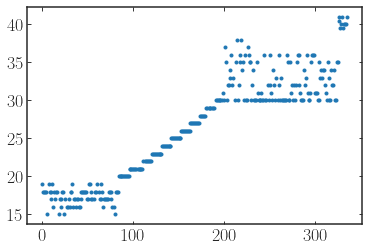

In [91]:
plt.plot(df.spt, '.')

In [87]:
import pickle
output = open(wisps.OUTPUT_FILES+'/validated_templates.pkl', 'wb')
pickle.dump(df, output)
output.close()


In [65]:
splat.typeToNum?